In [101]:
import pandas as pd
import numpy as np
#import graphlab as tc
import turicreate as tc
from tqdm.notebook import tqdm
import turicreate.aggregate as agg
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import pickle
import matplotlib.pyplot as plt

In [2]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw = mw.remove_column('fcount', inplace=True)

In [3]:
test_apns = np.load('../res/test-tc-1000.npy')

In [4]:
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [157]:
gamma = 0.6666666666666666
ref, mer = nets[gamma]

In [30]:
## recommender for all exclude test from similar items?

In [78]:
def tc_based_nn(net, apks, data):
    anch = list(net.keys())
    anch.extend(apks)
    allt = data.filter_by(values=anch, column_name='apk')

    m = len(anch)
    sim_recom = tc.item_similarity_recommender.create(
        allt, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=m, verbose=False)
    
    # smaller k could be an optimization here
    items =sim_recom.get_similar_items(apks, k=m)
    # recomendations excluding network anchors 
    fitems = items.filter_by(values=apks, column_name='similar', exclude=True)
    
    return fitems.groupby(key_column_names=['apk'], operations={'nn': tc.aggregate.ARGMAX('score', 'similar')})

In [81]:
nns = tc_based_nn(ref, list(test_apns), mw)

nns.head()

apk,nn
26561,3
16257,20486
12088,3
2464,9218
26001,3
19279,11
18741,18454
18939,2074
21368,3
11452,20486


In [82]:
# convert to votes

In [173]:
def s_conver_to_probs(v):
    return 1.0 - v[1]/(v[0]+v[1])

In [105]:
## full prediction

In [141]:
def eval_net(net, test_apns, data):
    nns = tc_based_nn(net, list(test_apns), data)
    return [s_conver_to_probs(net[row['nn']]) for row in nns.sort('apk')]


In [384]:
res = dict()
res_mer = dict()

#sorting to keep the results consistent (probs matching true values)
test_apns.sort()
true_values = [not labels.loc[a]['malware_label'] for a in test_apns]


for gamma, [ref, mer] in tqdm(nets.items()):
    res[gamma] = [eval_net(net=ref, test_apns=test_apns, data=mw), true_values]
    res_mer[gamma] = [eval_net(net=mer, test_apns=test_apns, data=mw), true_values]
    

  0%|          | 0/19 [00:00<?, ?it/s]

In [385]:
with open('../res/tc-new-res.pickle', 'wb+') as f:
    pickle.dump(res, f)

with open('../res/tc-new-mer.pickle', 'wb+') as f:
    pickle.dump(res_mer, f)

In [163]:
gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]

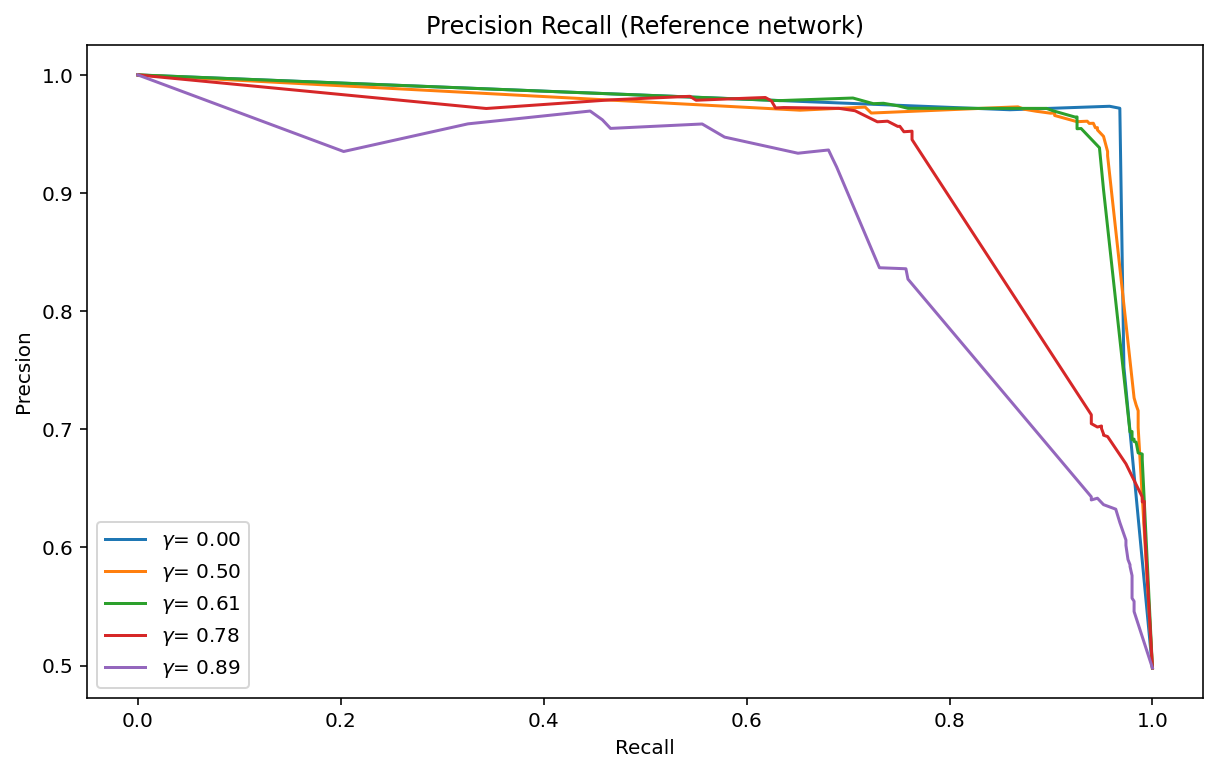

In [172]:
plt.figure(figsize=(10,6))
plt.title('Precision Recall (Reference network)')
plt.xlabel('Recall')
plt.ylabel('Precsion')
for gamma in gammas:
    probs, true_vals = res[gamma]
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs)
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}")
plt.legend();

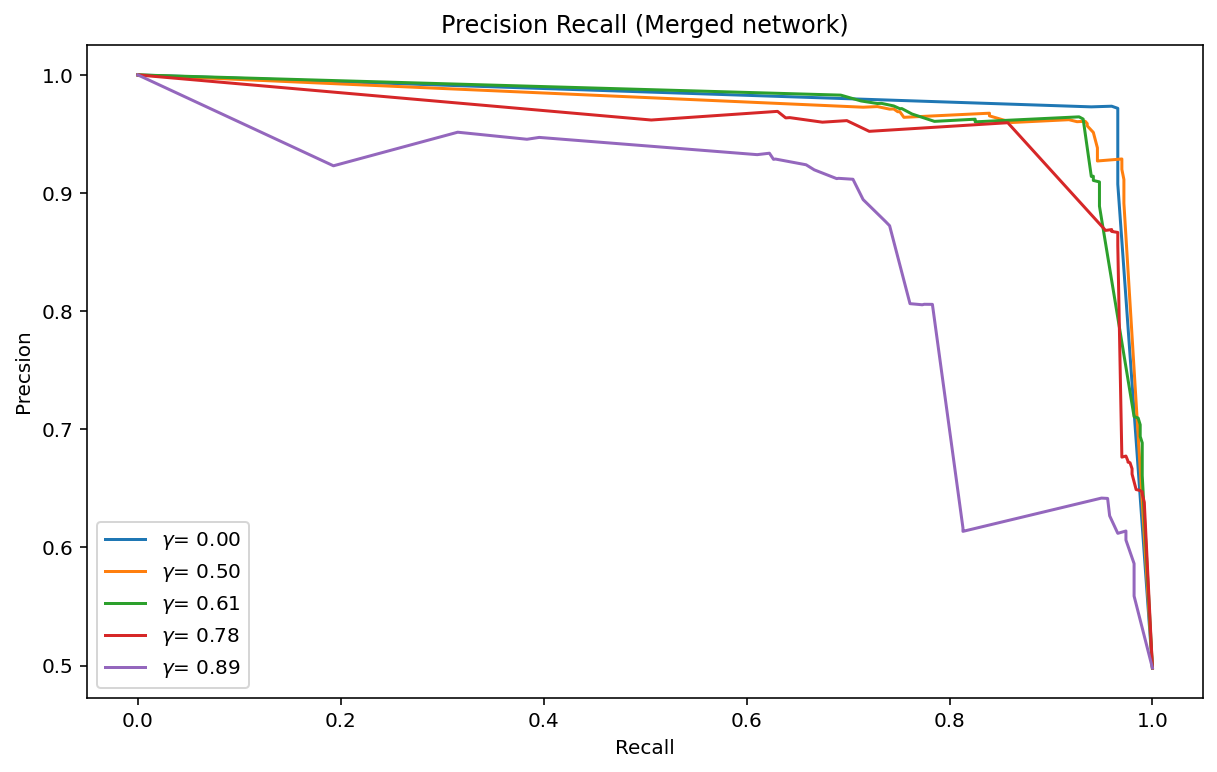

In [171]:
plt.figure(figsize=(10,6))
plt.title('Precision Recall (Merged network)')
plt.xlabel('Recall')
plt.ylabel('Precsion')
for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs)
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}")
plt.legend();
# AuC

In [183]:
# compression
d_size = sum(map(sum, mer.values()))

compr = dict()
for gamma, [ref, mer] in nets.items():
    compr[gamma] = [len(ref)/d_size, len(mer) /d_size]

df = pd.DataFrame.from_dict(compr, orient='index', columns=['ref', 'mer'])

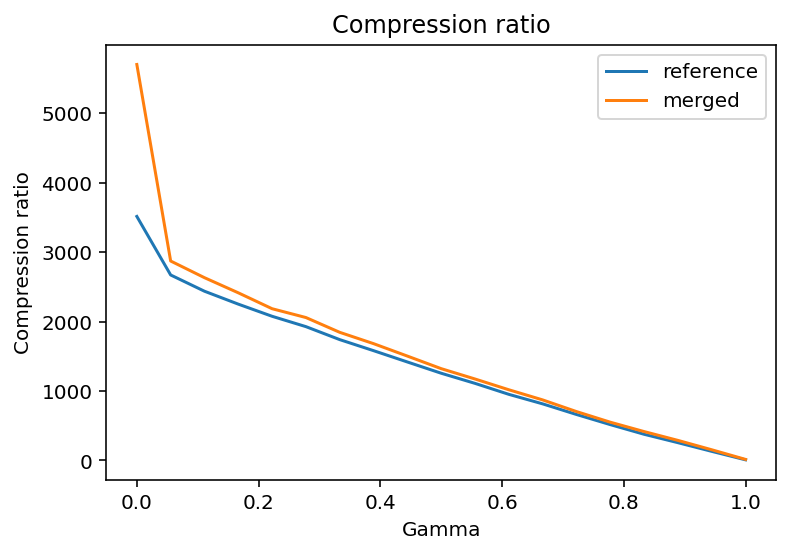

In [245]:
plt.title("Compression ratio ")
plt.plot(df.ref*d_size, label='reference')
plt.plot(df.mer*d_size, label='merged')
plt.xlabel('Gamma')
plt.ylabel('Compression ratio')
plt.legend();

In [246]:
d_size

9003

In [189]:
## not compressing to the end

In [188]:
ref, mer= nets[1.0]
print(len(ref), len(mer))

8 14


In [203]:
ref.keys(), mer.keys()

(dict_keys([0, 23424, 22784, 22529, 4177, 11019, 26380, 1559]),
 dict_keys([0, 8200, 2049, 22529, 22784, 15873, 6788, 11365, 11019, 26350, 4177, 16891, 11318, 1559]))

In [211]:
m = 1000
sim_recom = tc.item_similarity_recommender.create(
        mw, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=m, verbose=False)

In [194]:
items =sim_recom.get_similar_items(list(ref.keys()), k=m)

In [213]:
# does it said distance =1.0?
items.filter_by(values=list(ref.keys()), column_name='similar')

apk,similar,score,rank
15873,23424,0.25,62


In [200]:
s0 = set(mw[mw['apk']==0]['function'])
s23424 = set(mw[mw['apk']==23424]['function'])

In [201]:
s0.intersection(s23424)

set()

In [212]:
# same for merged:

items =sim_recom.get_similar_items(list(mer.keys()), k=m)
items.filter_by(values=list(mer.keys()), column_name='similar')
#items

apk,similar,score,rank
2049,11318,0.5,456
2049,11365,0.3999999761581421,592
2049,8200,0.3333333134651184,748
6788,8200,0.026315808296203613,675
11365,2049,0.3999999761581421,761
26350,2049,0.07692307233810425,374
26350,8200,0.07692307233810425,660
11318,2049,0.5,262


In [204]:
#s0 = set(mw[mw['apk']==0]['function'])
s8200 = set(mw[mw['apk']==8200]['function'])

In [205]:
s0.intersection(s8200)

{178583}

In [207]:
1 - len(s0 & s8200)/len(s0|s8200) 

0.9836065573770492

{178583}

In [216]:
with open('../res/1.0-tc-singlevoting.pickle', 'rb+') as f:
    las = pickle.load(f)

In [218]:
net = las[1.0]

In [221]:
net

({16393: [939, 1146],
  18946: [126, 27],
  4128: [0, 8],
  1960: [3, 1],
  5969: [0, 1]},
 {24576: [1152, 1093], 22529: [0, 1], 12387: [0, 4], 1559: [0, 1]},
 {0: [1138, 1069],
  22784: [0, 6],
  23424: [0, 18],
  26380: [1, 16],
  3425: [0, 1],
  25969: [0, 2]},
 {16384: [994, 645],
  2049: [159, 425],
  11652: [0, 4],
  18502: [5, 2],
  14013: [0, 14],
  4177: [0, 1],
  11019: [1, 0]})

In [229]:
len(mer.keys())

14

In [226]:
ks = list()
for n in net:
    ks.extend(list(n.keys()))

In [228]:
len(ks)

22

In [230]:
dats = mw.filter_by(values=ks, column_name='apk')

In [232]:
m = 1000
sim_recom = tc.item_similarity_recommender.create(
        dats, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        only_top_k=m, verbose=False)

In [243]:
mer.keys()

dict_keys([0, 8200, 2049, 22529, 22784, 15873, 6788, 11365, 11019, 26350, 4177, 16891, 11318, 1559])

In [239]:
items = sim_recom.get_similar_items(ks, k=100)
items[items['apk']==16393]

apk,similar,score,rank
16393,2049,1.0,1
16393,26380,0.25,2
16393,0,0.016393423080444336,3
16393,24576,0.0004839301109313965,4


In [242]:
items[items['score']>=1-1.0].groupby(key_column_names='apk', operations={'sims': agg.DISTINCT('similar')})

apk,sims
18946,"[16384, 24576, 23424, 0,12387] ..."
4128,"[14013, 0, 24576]"
2049,"[16393, 24576, 26380, 0]"
11019,[24576]
16393,"[2049, 24576, 26380, 0]"
4177,"[25969, 24576]"
0,"[16384, 24576, 18502,4128, 14013, 18946, 1 ..."
22784,"[18502, 1960, 24576]"
11652,"[3425, 5969, 22529]"
1960,"[18502, 24576, 22784, 0]"


In [247]:
gw

apk,sims
18946,"[16384, 24576, 23424, 0,12387] ..."
4128,"[14013, 0, 24576]"
2049,"[16393, 24576, 26380, 0]"
11019,[24576]
16393,"[2049, 24576, 26380, 0]"
4177,"[25969, 24576]"
0,"[16384, 24576, 18502,4128, 14013, 18946, 1 ..."
22784,"[18502, 1960, 24576]"
11652,"[3425, 5969, 22529]"
1960,"[18502, 24576, 22784, 0]"


## TODOs
1. AuC to actually compare the merged and reference network
1. slope of the compression curve
1. debug the netowrk creation strange results
1. streaming-based creation

### Streaming-based creation
1. partition data,
1. create network for the first partition
1. use their anchors to calculate (update) networks for other
- prediction?
1. merge (concatation)

In [320]:
## stream eval

In [323]:
with open('../res/9003-stream-nets.pickle', 'rb') as f:
    st_nets = pickle.load(f)

In [325]:
for gamma, [merged, voting] in st_nets.items():
    print(gamma, sum(map(sum, voting.values())))

0.0 9003
0.05555555555555555 9003
0.1111111111111111 9003
0.16666666666666666 9003
0.2222222222222222 9003
0.2777777777777778 9003
0.3333333333333333 9003
0.3888888888888889 9003
0.4444444444444444 9003
0.5 9003
0.5555555555555556 9003
0.6111111111111112 9003
0.6666666666666666 9003
0.7222222222222222 9003
0.7777777777777778 9003
0.8333333333333334 9003
0.8888888888888888 9003
0.9444444444444444 9003
1.0 8997


In [326]:
gamma = 0.6666666666666666

In [327]:
[merged, voting]  = st_nets[gamma]

In [ ]:
test_apns.sort()
true_values = [not labels.loc[a]['malware_label'] for a in test_apns]

In [332]:
probs = dict()
for gamma, [merged, voting] in tqdm(st_nets.items()):
    probs[gamma] = eval_net(net=voting, test_apns=test_apns, data=mw)

  0%|          | 0/19 [00:00<?, ?it/s]

In [379]:
with open('../res/tc-stream-probs.pickle', 'wb+') as f:
    pickle.dump(probs, f)


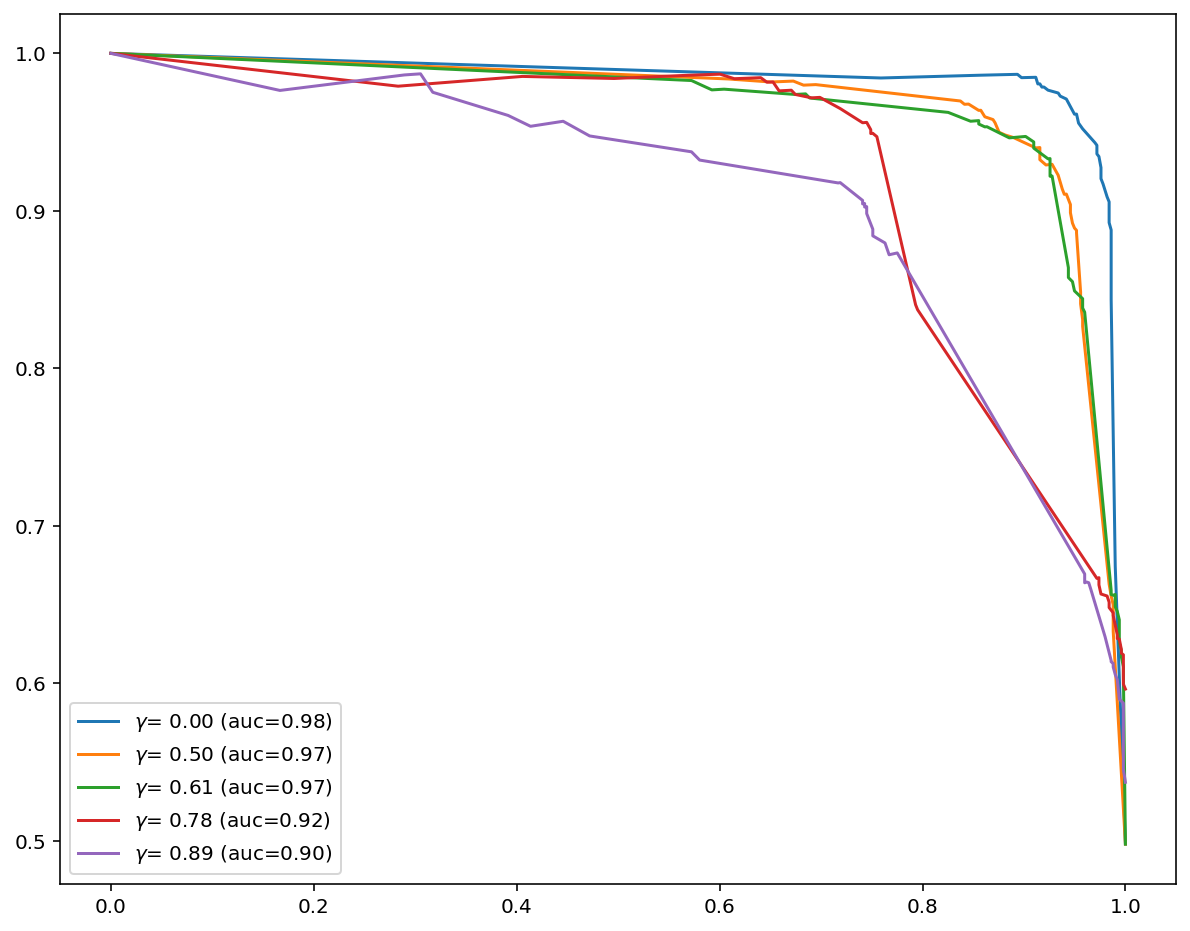

In [377]:
gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]
plt.figure(figsize=(10,8))
for gamma in gammas:
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs[gamma])
    roc_auc = metrics.roc_auc_score(true_vals, probs[gamma])
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f} (auc={roc_auc:.2f})")
plt.legend();

In [364]:
# auc
from sklearn import metrics

In [370]:
gamma = 0.8888888888888888
metrics.roc_auc_score(true_vals, probs[gamma]) 


0.9034244547912766

In [359]:
size = sum(map(sum, st_nets[0.0][1].values()))
comp = {gamma: len(voting) for gamma, [merged, voting] in st_nets.items()}
    

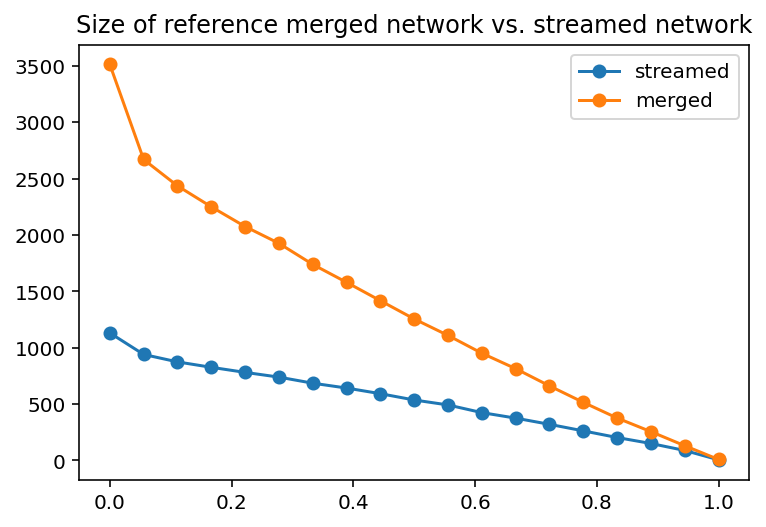

In [361]:
plt.title('Size of reference merged network vs. streamed network')
plt.plot(list(comp.keys()), list(comp.values()),'-o', label='streamed')
plt.plot(df.ref*d_size, '-o', label='merged')
plt.legend();

In [356]:
single_nets = dict()
for gamma in st_nets.keys():
    with open(f"../res/{gamma}-tc-singlevoting.pickle", 'rb') as f:
        nw = pickle.load(f)
        single_nets[gamma] = nw[gamma]

In [358]:
single_sizes = {g:len(a[0]) for g, a in single_nets.items()}

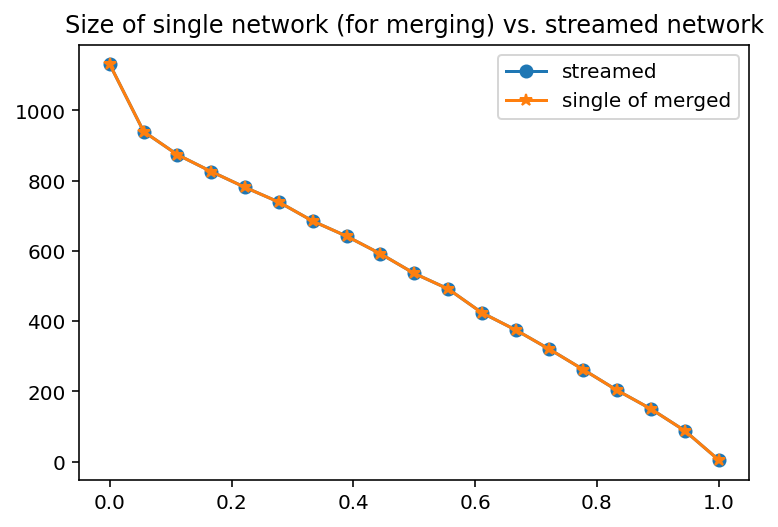

In [363]:
plt.title('Size of single network (for merging) vs. streamed network')
plt.plot(list(comp.keys()), list(comp.values()),'-o', label='streamed')
plt.plot(list(single_sizes.keys()), list(single_sizes.values()), '-*', label='single of merged')
plt.legend();

In [378]:
# Precision comprarision between streamed and merged

In [387]:
with open('../res/tc-new-mer.pickle', 'rb') as f:
    res_mer = pickle.load(f)

In [388]:
with open('../res/tc-stream-probs.pickle', 'rb') as f:
    res_str = pickle.load(f)

In [405]:
gammas = list(res_mer.keys())[:-1]
to_plot=dict()

for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, res_str[gamma])
    roc_auc1 = metrics.roc_auc_score(true_vals, probs) 
    
    [p2, r2, thresholds] = precision_recall_curve(true_vals, probs)
    roc_auc2 = metrics.roc_auc_score(true_vals, res_str[gamma])

    to_plot[gamma] = [p1, r1, roc_auc1, p2, r2, roc_auc2]

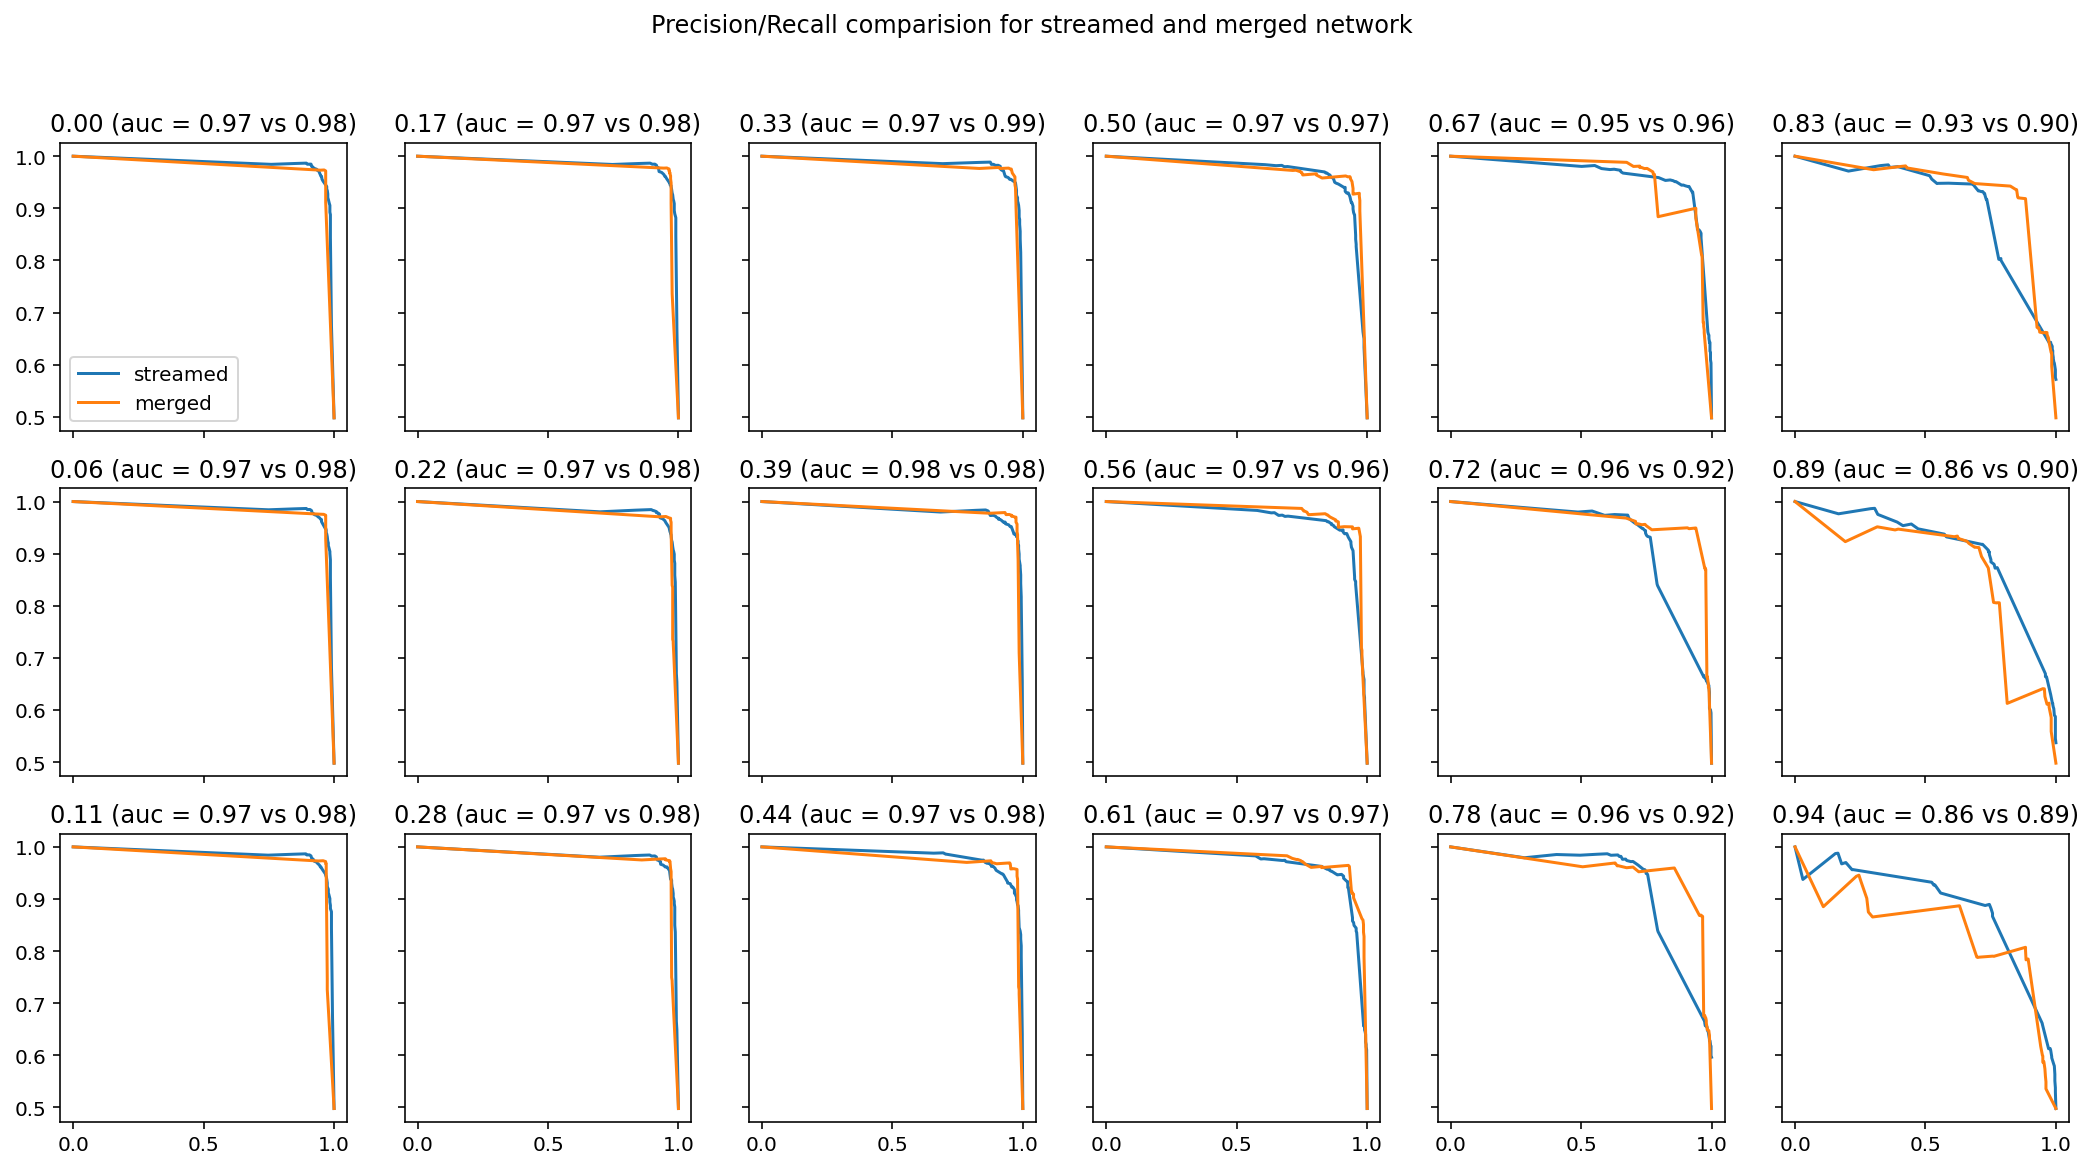

In [428]:
rows = 3
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(18, 9), sharex=True, sharey=True)
fig.suptitle('Precision/Recall comparision for streamed and merged network')
for i, gamma in enumerate(to_plot.keys()):
    [p1, r1, roc_auc1, p2, r2, roc_auc2] = to_plot[gamma]
    axs[i%rows, i//rows].plot(r1, p1, label='streamed')
    axs[i%rows, i//rows].plot(r2, p2, label='merged')
    axs[i%rows, i//rows].set_title(f"{gamma:.2f} (auc = {roc_auc1:.2f} vs {roc_auc2:.2f})")

axs[0,0].legend();